In [57]:
from pathlib import Path

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib_fontja
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import linkage, dendrogram
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import KeyedVectors as Vectors
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

BASE_PATH = Path('./')


## 60

In [7]:
model: Vectors = KeyedVectors.load_word2vec_format(BASE_PATH / 'GoogleNews-vectors-negative300.bin', binary=True)
model.get_vector('United_States')


array([-3.61328125e-02, -4.83398438e-02,  2.35351562e-01,  1.74804688e-01,
       -1.46484375e-01, -7.42187500e-02, -1.01562500e-01, -7.71484375e-02,
        1.09375000e-01, -5.71289062e-02, -1.48437500e-01, -6.00585938e-02,
        1.74804688e-01, -7.71484375e-02,  2.58789062e-02, -7.66601562e-02,
       -3.80859375e-02,  1.35742188e-01,  3.75976562e-02, -4.19921875e-02,
       -3.56445312e-02,  5.34667969e-02,  3.68118286e-04, -1.66992188e-01,
       -1.17187500e-01,  1.41601562e-01, -1.69921875e-01, -6.49414062e-02,
       -1.66992188e-01,  1.00585938e-01,  1.15722656e-01, -2.18750000e-01,
       -9.86328125e-02, -2.56347656e-02,  1.23046875e-01, -3.54003906e-02,
       -1.58203125e-01, -1.60156250e-01,  2.94189453e-02,  8.15429688e-02,
        6.88476562e-02,  1.87500000e-01,  6.49414062e-02,  1.15234375e-01,
       -2.27050781e-02,  3.32031250e-01, -3.27148438e-02,  1.77734375e-01,
       -2.08007812e-01,  4.54101562e-02, -1.23901367e-02,  1.19628906e-01,
        7.44628906e-03, -

## 61

In [8]:
model.similarity('United_States', 'U.S.')


0.73107743

## 62

In [9]:
model.similar_by_key('United_States')


[('Unites_States', 0.7877248525619507),
 ('Untied_States', 0.7541370987892151),
 ('United_Sates', 0.7400724291801453),
 ('U.S.', 0.7310774326324463),
 ('theUnited_States', 0.6404393911361694),
 ('America', 0.6178410053253174),
 ('UnitedStates', 0.6167312264442444),
 ('Europe', 0.6132988929748535),
 ('countries', 0.6044804453849792),
 ('Canada', 0.601906955242157)]

## 63

In [10]:
spain = model.get_vector('Spain')
madrid = model.get_vector('Madrid')
athens = model.get_vector('Athens')

res = spain - madrid + athens
model.similar_by_key(res)


[('Athens', 0.7528455853462219),
 ('Greece', 0.6685472130775452),
 ('Aristeidis_Grigoriadis', 0.5495778322219849),
 ('Ioannis_Drymonakos', 0.5361457467079163),
 ('Greeks', 0.5351786017417908),
 ('Ioannis_Christou', 0.5330225825309753),
 ('Hrysopiyi_Devetzi', 0.5088489055633545),
 ('Iraklion', 0.5059264302253723),
 ('Greek', 0.5040615797042847),
 ('Athens_Greece', 0.5034108757972717)]

## 64

In [33]:
with open(BASE_PATH / 'questions-words.txt') as f:
    data = [i.rstrip().split() for i in f.readlines()]

category = ''
categories = []
word1 = []
word2 = []
word3 = []
word4 = []
pred = []
similarity = []
for d in tqdm(data):
    if len(d) == 2:
        category = d[1]
    else:
        w1, w2, w3, w4 = d
        word1.append(w1)
        word2.append(w2)
        word3.append(w3)
        word4.append(w4)
        categories.append(category)

        p = model.most_similar(positive=[w2, w3], negative=[w1], topn=1)[0]
        pred.append(p[0])
        similarity.append(p[1])


  0%|          | 0/19558 [00:00<?, ?it/s]

100%|██████████| 19558/19558 [41:45<00:00,  7.81it/s]


In [34]:
df = pl.DataFrame({
    '1st word': word1,
    '2nd word': word2,
    '3rd word': word3,
    'y_true': word4,
    'category': categories,
    'y_pred': pred,
    'similarity': similarity,
})

display(df.head())


1st word,2nd word,3rd word,y_true,category,y_pred,similarity
str,str,str,str,str,str,f64
"""Athens""","""Greece""","""Baghdad""","""Iraq""","""capital-common-countries""","""Iraqi""",0.635187
"""Athens""","""Greece""","""Bangkok""","""Thailand""","""capital-common-countries""","""Thailand""",0.713767
"""Athens""","""Greece""","""Beijing""","""China""","""capital-common-countries""","""China""",0.723578
"""Athens""","""Greece""","""Berlin""","""Germany""","""capital-common-countries""","""Germany""",0.673462
"""Athens""","""Greece""","""Bern""","""Switzerland""","""capital-common-countries""","""Switzerland""",0.491975


## 65

In [35]:
se_df = df.filter(~pl.col('category').str.contains('gram'))
sy_df = df.filter(pl.col('category').str.contains('gram'))
print(np.sum((se_df['y_true'] == se_df['y_pred']).to_numpy())/len(se_df))
print(np.sum((sy_df['y_true'] == sy_df['y_pred']).to_numpy())/len(sy_df))


0.7308602999210734
0.7400468384074942


## 66

In [39]:
combined_df = pl.read_csv('./wordsim353/combined.csv')

word_1 = combined_df['Word 1']
word_2 = combined_df['Word 2']
gensim_pred = []
for i in range(len(word_1)):
  w1, w2 = word_1[i], word_2[i]
  p = model.similarity(w1, w2)
  gensim_pred.append(p)

spearmanr(combined_df['Human (mean)'], gensim_pred)


SignificanceResult(statistic=0.7000166486272194, pvalue=2.86866666051422e-53)

## 67

In [ ]:
with open('questions-words.txt') as f:
  data_ = [i.rstrip().split() for i in f.readlines()]

countries = set()
flag = 0
for d in data_:
  if len(d) == 2:
    if d[1] == 'city-in-state':
      break

    if d[1].startswith('capital'):
      flag = 1
    else:
      flag = 0
  else:
    if flag:
      _, c1, _, c2 = d
    else:
      c1, _, c2, _ = d

    countries.add(c2)
    countries.add(c1)

countries = list(countries)
countries_vector = [model.get_vector(c) for c in countries]

kmeans = KMeans(n_clusters=5)

res =  kmeans.fit(countries_vector)
kmeans_cluster = [[] for _ in range(5)]
for i, label in enumerate(res.labels_):
  kmeans_cluster[label].append(countries[i])

kmeans_cluster


[['Tunisia',
  'Taiwan',
  'Pakistan',
  'Indonesia',
  'Iraq',
  'India',
  'Oman',
  'Cuba',
  'Syria',
  'Malaysia',
  'Afghanistan',
  'Libya',
  'Lebanon',
  'Jordan',
  'Bangladesh',
  'Sudan',
  'Korea',
  'Algeria',
  'Somalia',
  'Bhutan',
  'Philippines',
  'Nicaragua',
  'Nepal',
  'Egypt',
  'China',
  'Vietnam',
  'Thailand',
  'Eritrea',
  'Iran',
  'Qatar',
  'Peru',
  'Cambodia',
  'Venezuela',
  'Morocco',
  'Bahrain',
  'Laos'],
 ['Uzbekistan',
  'Kyrgyzstan',
  'Russia',
  'Ukraine',
  'Moldova',
  'Armenia',
  'Tajikistan',
  'Belarus',
  'Kazakhstan',
  'Turkmenistan',
  'Azerbaijan'],
 ['Rwanda',
  'Burundi',
  'Ecuador',
  'Liberia',
  'Suriname',
  'Jamaica',
  'Zambia',
  'Angola',
  'Honduras',
  'Gambia',
  'Bahamas',
  'Niger',
  'Samoa',
  'Ghana',
  'Belize',
  'Guyana',
  'Zimbabwe',
  'Dominica',
  'Senegal',
  'Nigeria',
  'Madagascar',
  'Guinea',
  'Namibia',
  'Fiji',
  'Uganda',
  'Mali',
  'Gabon',
  'Mozambique',
  'Malawi',
  'Kenya',
  'Botswana

## 68

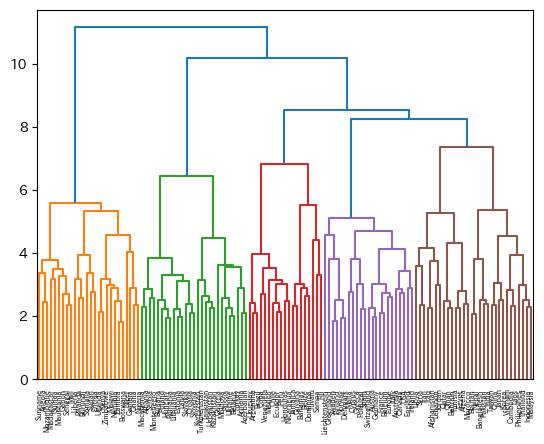

In [56]:
link = linkage(countries_vector, method='ward')
dendrogram(link, labels=countries)
plt.show()


## 69

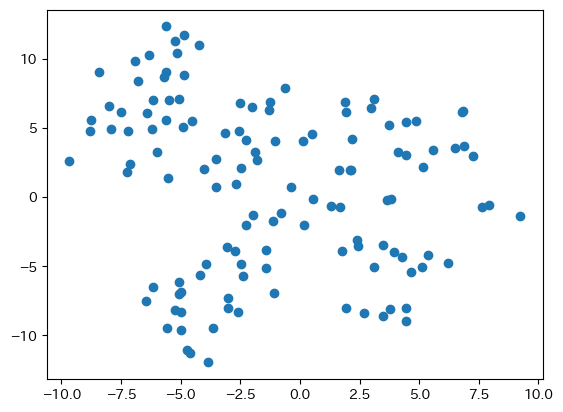

In [62]:
tsne = TSNE(random_state=42)
res_tsne = tsne.fit_transform(np.array(countries_vector))

plt.scatter(res_tsne[:, 0], res_tsne[:, 1])
plt.show()
